In [3]:
import pandas as pd
from datetime import timedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import sys, os
import MySQLdb
sys.path.append(os.path.abspath("..")) 
from IPython.display import display
from tabulate import tabulate
import matplotlib.dates as mdates

conn = MySQLdb.connect(
    host='127.0.0.1',
    port=3333,
    user=os.getenv("DB_USER"),
    passwd=os.getenv("DB_PASSWORD"),
    db=os.getenv("DB_NAME")
)


query = """
    SELECT 
        ms.*,
        c.name,
        c.rating,
        c.version,
        c.position,
        c.current_ps_price,
        c.current_pc_price
    FROM market_sales ms
    JOIN meta_cards mc ON ms.card_id = mc.card_id
    JOIN cards c ON ms.card_id = c.card_id
"""
df_26 = pd.read_sql(query, conn)


df_26 = df_26.sort_values('sale_time', ascending=False)

def clean_group(g):
    # 1. Separate unsold cards (sold_price is 0 or NaN/NULL)
    # The unsold cards should be preserved completely.
    unsold = g[g['sold_price'].isnull() | (g['sold_price'] == 0)]
    
    # 2. Filter the sold cards (where sold_price > 0)
    sold = g[g['sold_price'] > 0]
    
    # 3. Apply Outlier Cleaning ONLY to the sold cards
    if len(sold) >= 10:
        low = sold['sold_price'].quantile(0.05)
        high = sold['sold_price'].quantile(0.95)
        sold_clean = sold[(sold['sold_price'] >= low) & (sold['sold_price'] <= high)]
    else:
        sold_clean = sold # Keep them all if too few data points for robust quantile
        
    # 4. Combine the cleaned sold cards with the preserved unsold cards
    return pd.concat([sold_clean, unsold])

# The rest of your Python code remains the same:
df_clean_full = df_26.groupby('card_id', group_keys=False).apply(clean_group).reset_index(drop=True)

conn.close()

C:\Users\shane\AppData\Local\Temp\ipykernel_2688\2832829804.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_26 = pd.read_sql(query, conn)
C:\Users\shane\AppData\Local\Temp\ipykernel_2688\2832829804.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean_full = df_26.groupby('card_id', group_keys=False).apply(clean_group).reset_index(drop=True)


## Correlation Between Mean Price of Cards and Demand of Cards Using **Pearson's Correlation Coefficient**

Using Frimpong as Subject

In [34]:
end_time = df_clean_full['sale_time'].max().floor('h')   # latest hour in data
start_time = end_time - pd.Timedelta(days=3)

frimpong_df = df_26[df_26['card_id'] == 882].copy()
print(frimpong_df['sale_time'].max().floor('h'))
df_24h_frimpong = frimpong_df[(frimpong_df['sale_time'] > start_time) & (frimpong_df['sale_time'] <= end_time)]

if df_24h_frimpong.empty:
    print("No trades in last 24h, using last 7 days instead")
    start_time = end_time - timedelta(days=7)
    df_24h_frimpong = frimpong_df[
        (frimpong_df['sale_time'] > start_time) & 
        (frimpong_df['sale_time'] <= end_time)
    ]
    


df_24h_frimpong['sale_hour'] = df_24h_frimpong['sale_time'].dt.floor('h')   # round down to the hou

frimpong_demand_df = (
    df_24h_frimpong.groupby(['card_id', 'sale_hour'])
    .size()
    .reset_index(name='sales_count')
)

frimpong_price_df = (
    df_24h_frimpong.groupby(['card_id', 'sale_hour'])
    ['sold_price'].median()   # or .mean()
    .reset_index(name='median_price')
)

def pearsons_corr(demand_df, price_df):
    merged = pd.merge(demand_df, price_df, on=['card_id', 'sale_hour'])
    if len(merged) < 2:
        return None  # not enough data points to calculate correlation
    return merged['sales_count'].corr(merged['median_price'])


r = pearsons_corr(frimpong_demand_df, frimpong_price_df)
print("Pearson correlation:", r)

2025-09-30 08:00:00
No trades in last 24h, using last 7 days instead
Pearson correlation: -0.029667521155543223


C:\Users\shane\AppData\Local\Temp\ipykernel_33296\692546274.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_24h_frimpong['sale_hour'] = df_24h_frimpong['sale_time'].dt.floor('h')   # round down to the hou


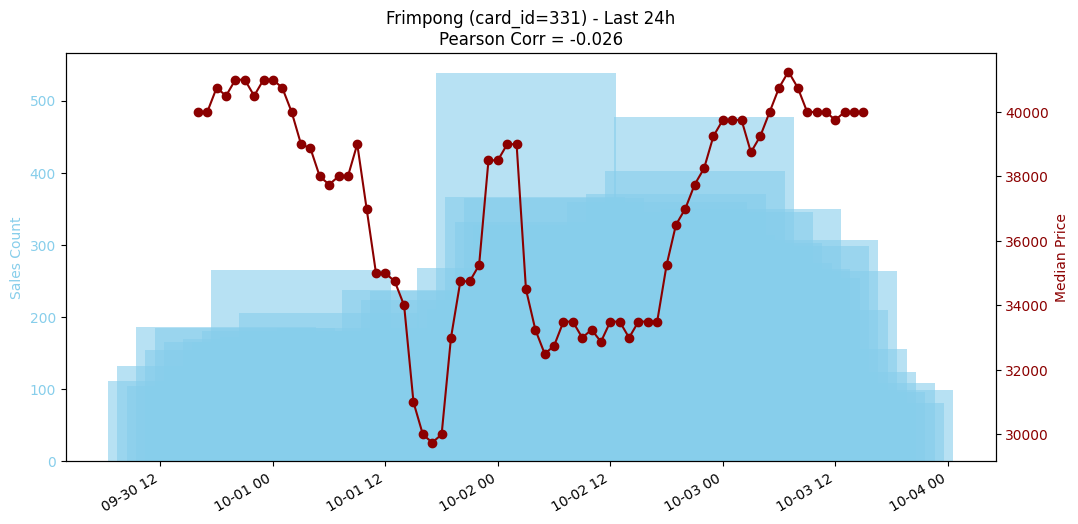

In [33]:
# Merge demand + price for plotting
frimpong_merged = pd.merge(frimpong_demand_df, frimpong_price_df, on=['card_id','sale_hour'])

fig, ax1 = plt.subplots(figsize=(12,6))

# Bar plot for demand (sales_count)
ax1.bar(frimpong_merged['sale_hour'], frimpong_merged['sales_count'], 
        color='skyblue', alpha=0.6, label='Sales Count')
ax1.set_ylabel('Sales Count', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Line plot for price (median_price)
ax2 = ax1.twinx()
ax2.plot(frimpong_merged['sale_hour'], frimpong_merged['median_price'], 
         color='darkred', marker='o', label='Median Price')
ax2.set_ylabel('Median Price', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

# Title with correlation
if r is None:
    plt.title("Frimpong (card_id=331) - Last 24h\nPearson Corr = Not enough data")
else:
    plt.title(f"Frimpong (card_id=331) - Last 24h\nPearson Corr = {r:.3f}")
fig.autofmt_xdate()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np # Import numpy if needed for advanced calculations

# Ensure 'df_window' is loaded/defined before this script runs

df = df_window[
    (df_window['platform'] == "pc") & 
    (df_window['version'].str.strip().str.lower() == "gold rare") &
    (df_window['version'].notna())
].copy()

# --- Filter the last week ---
df['sale_time'] = pd.to_datetime(df['sale_time'])
# Use 14 days as requested
one_week_ago = df['sale_time'].max() - pd.Timedelta(days=14) 
df_last_week = df[df['sale_time'] >= one_week_ago].copy()

# --- REMOVE BAD DATA DAY ---
# Based on your input (4 days dropping, plus the bad day before that), 
# this calculates the date 5 days before the latest data point to exclude 
# the faulty Thursday. Adjust the 'days=5' if the date is different.
latest_date = df_last_week['sale_time'].max().normalize()
date_to_exclude = latest_date - pd.Timedelta(days=4)

# Filter out the entire day (hour-by-hour) of the faulty scraper run
df_last_week = df_last_week[
    df_last_week['sale_time'].dt.normalize() != date_to_exclude
].copy()

print(f"Data filtered to the last 14 days, excluding all sales from: {date_to_exclude.date()}")
# ---------------------------

# --- Resample hourly: average sold price ---
df_last_week.set_index('sale_time', inplace=True)
avg_price_per_hour = df_last_week['sold_price'].resample('1H').mean()

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(avg_price_per_hour.index, avg_price_per_hour.values, marker='o', linestyle='-', color='#1e90ff')
plt.title(f"Average Card Sold Price Over Last 14 Days (Excluding {date_to_exclude.date()})", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Average Sold Price", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Market Crash Detector

In [ ]:
def detect_crash_continuation(df, lookback_hours=3, interval_minutes=30, drop_threshold=-0.02):
    """
    Detects if the market is still crashing based on rolling 30-min price slopes.
    
    Parameters:
        df: DataFrame with ['sale_time', 'sold_price', 'card_id']
        lookback_hours: How far back to check (e.g. last 3 hours)
        interval_minutes: Interval size for rolling slope checks
        drop_threshold: Minimum negative slope (% change) to count as a crash continuation
        
    Returns:
        bool: True if market still crashing (prices falling), False otherwise
    """
    if df.empty or 'sale_time' not in df or 'sold_price' not in df:
        return False
    
    latest_time = df['sale_time'].max()
    start_time = latest_time - timedelta(hours=lookback_hours)
    recent_df = df[df['sale_time'] >= start_time].copy()

    if recent_df.empty:
        return False

    # --- 1. Resample into 30-min intervals per card ---
    recent_df.set_index('sale_time', inplace=True)
    interval = f'{interval_minutes}T'
    slopes = []

    for card_id, group in recent_df.groupby('card_id'):
        # Average price per 30min interval
        resampled = group['sold_price'].resample(interval).mean().dropna()
        if len(resampled) < 3:
            continue

        # Compute rolling slope (price trend)
        slope = (resampled.pct_change().tail(3).mean())  # mean of last few pct changes
        slopes.append(slope)

    if not slopes:
        return False

    avg_slope = pd.Series(slopes).mean()

    # Market still crashing if latest slopes are significantly negative
    is_crashing = avg_slope < drop_threshold
    return is_crashing

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

def detect_market_crashes(sales_df, interval_minutes=60, card_threshold=0.1, drop_threshold=0.06):
    """
    Detects market-wide crashes vs local dips over the last 7 days.
    
    Parameters:
        sales_df: DataFrame with ['card_id', 'sale_time', 'sold_price']
        interval_minutes: window granularity (e.g., 30min)
        card_threshold: fraction of cards dropping to count as a market crash (e.g., 0.4 = 40%)
        drop_threshold: % drop to consider a card "crashing" (e.g., 0.1 = 10%)
    """
    # Sort & filter to last 7 days
    sales_df = sales_df.sort_values('sale_time')
    latest_time = sales_df['sale_time'].max()
    start_time = latest_time - timedelta(days=14)
    sales_df = sales_df[sales_df['sale_time'] >= start_time]

    # Round timestamps to nearest interval (e.g. 30min)
    sales_df['time_bin'] = (sales_df['sale_time'].dt.floor(f'{interval_minutes}T'))

    # Compute average price per card per interval
    grouped = sales_df.groupby(['time_bin', 'card_id'])['sold_price'].mean().reset_index()

    # Pivot to wide format: rows = time bins, columns = cards
    price_matrix = grouped.pivot(index='time_bin', columns='card_id', values='sold_price').ffill().bfill()

    # Calculate % change per interval
    pct_change = price_matrix.pct_change()

    # Compute what fraction of cards are dropping significantly
    crash_fraction = (pct_change < -drop_threshold).sum(axis=1) / pct_change.shape[1]

    # Define crash type
    crash_state = pd.Series(index=crash_fraction.index, dtype=str)
    crash_state[crash_fraction > card_threshold] = "Market Crash"
    crash_state[crash_fraction < 0.04] = "Stable"

    # Combine into summary DataFrame
    crash_summary = pd.DataFrame({
        'crash_fraction': crash_fraction,
        'crash_state': crash_state
    }).fillna('Stable')

    # --- Plot ---
    plt.figure(figsize=(12,5))
    plt.plot(crash_summary.index, crash_summary['crash_fraction'], label='Crash Fraction')
    plt.axhline(y=card_threshold, color='red', linestyle='--', label='Market Crash Threshold')
    plt.title("📉 Market Crash Intensity (Last 7 Days)")
    plt.xlabel("Time")
    plt.ylabel("Fraction of Cards Dropping > 10% per Interval")
    plt.legend()
    plt.grid(True)
    plt.show()

    return crash_summary


C:\Users\shane\AppData\Local\Temp\ipykernel_21008\1273298276.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sales_df['time_bin'] = (sales_df['sale_time'].dt.floor(f'{interval_minutes}T'))
C:\Users\shane\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


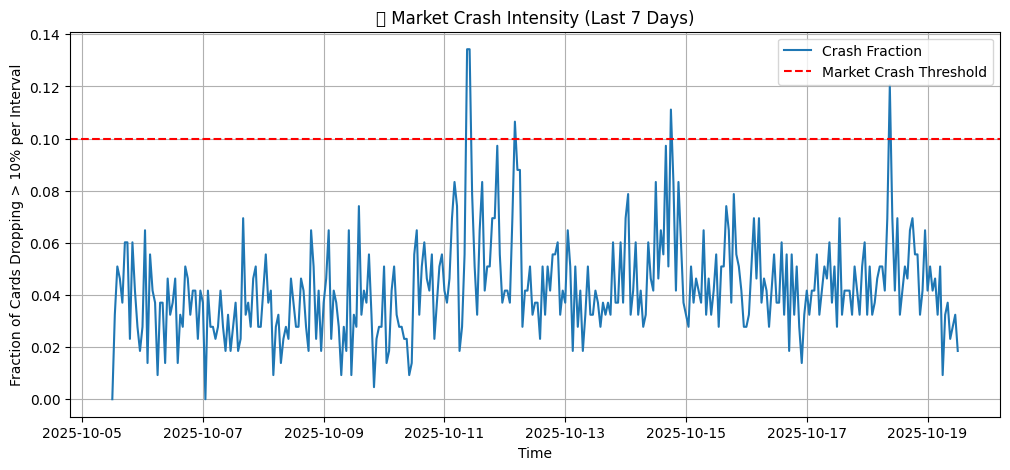

                     crash_fraction crash_state
time_bin                                       
2025-10-05 12:00:00        0.000000      Stable
2025-10-05 13:00:00        0.032407      Stable
2025-10-05 14:00:00        0.050926      Stable
2025-10-05 15:00:00        0.046296      Stable
2025-10-05 16:00:00        0.037037      Stable
...                             ...         ...
2025-10-19 08:00:00        0.037037      Stable
2025-10-19 09:00:00        0.023148      Stable
2025-10-19 10:00:00        0.027778      Stable
2025-10-19 11:00:00        0.032407      Stable
2025-10-19 12:00:00        0.018519      Stable

[337 rows x 2 columns]


In [31]:
df = df_clean_full[df_clean_full['platform'] == "pc"].copy()
crash_summary = detect_market_crashes(df)

print(crash_summary)


C:\Users\shane\AppData\Local\Temp\ipykernel_21008\4289865208.py:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sales_df['time_bin'] = (sales_df['sale_time'].dt.floor(f'{interval_minutes}T'))
C:\Users\shane\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


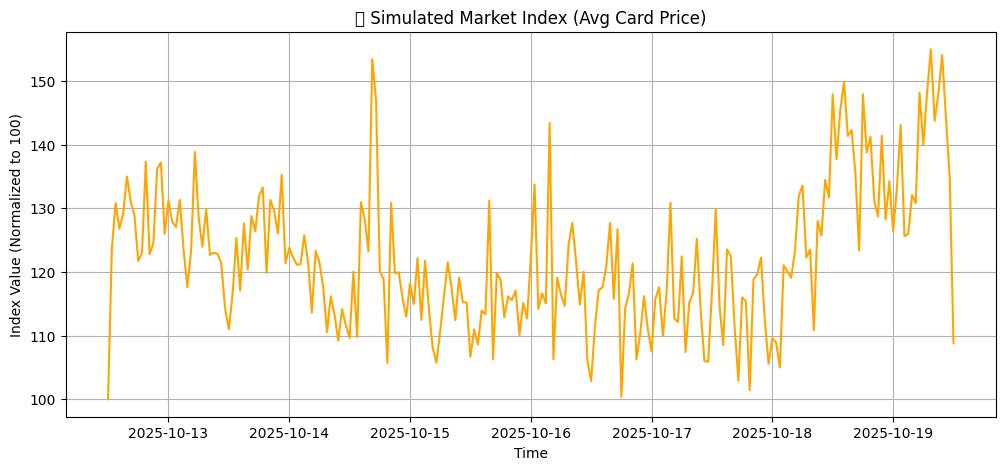

In [44]:
# --- Add this function to your code to create the index ---

def calculate_market_index(sales_df, interval_minutes=120):
    """
    Calculates a simple market index (average price of all cards)
    based on the average sale price in each time interval.
    """
    # 1. Prepare data (similar to crash detection setup)
    sales_df = sales_df.sort_values('sale_time')
    latest_time = sales_df['sale_time'].max()
    start_time = latest_time - timedelta(days=7)
    sales_df = sales_df[sales_df['sale_time'] >= start_time]

    # 2. Round timestamps to nearest interval
    sales_df['time_bin'] = (sales_df['sale_time'].dt.floor(f'{interval_minutes}T'))

    # 3. Calculate the average price of ALL sales in that time bin
    # This creates a single time series: the Market Index
    market_index = sales_df.groupby('time_bin')['sold_price'].mean()
    
    # Optional: Normalize the index so it starts at 100 or 75 (like the Futbin graph)
    # This makes it easier to read the relative change
    initial_value = market_index.iloc[0] if not market_index.empty else 1
    market_index_normalized = (market_index / initial_value) * 100
    
    return market_index_normalized.rename("Index Value")

# --- Plot the Index ---
# After calling your existing detect_market_crashes function, run this:
market_index = calculate_market_index(df, interval_minutes=45)
plt.figure(figsize=(12,5))
plt.plot(market_index.index, market_index.values, color='orange', label='Market Index')
plt.title("📈 Simulated Market Index (Avg Card Price)")
plt.xlabel("Time")
plt.ylabel("Index Value (Normalized to 100)")
plt.grid(True)
plt.show()

In [60]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

# --- CONFIGURATION PARAMETERS ---
HISTORICAL_DAYS = 7
INTERVAL_MINUTES = 30 

def calculate_historical_avg_volume(sales_df, days=HISTORICAL_DAYS, interval_minutes=INTERVAL_MINUTES):
    """
    Calculates the average volume (total sales count) per time interval 
    over a specified historical period (default: 7 days).
    
    Args:
        sales_df (pd.DataFrame): DataFrame containing 'sale_time' and sales data.
        days (int): The number of days back to look for the historical period.
        interval_minutes (int): The size of the bin (in minutes) for averaging.
        
    Returns:
        float: The mean number of sales observed per interval.
    """
    sales_df = sales_df.sort_values('sale_time')
    if sales_df.empty:
        print("Error: Sales DataFrame is empty.")
        return 0
        
    end_time = sales_df['sale_time'].max()
    start_time = end_time - timedelta(days=days)
    
    # 1. Filter data to the historical window
    historical_df = sales_df[(sales_df['sale_time'] >= start_time) & (sales_df['sale_time'] <= end_time)].copy()
    
    if historical_df.empty:
        print(f"Error: No data found in the last {days} days.")
        return 0
        
    # 2. Bin the data based on the interval
    historical_df['time_bin'] = historical_df['sale_time'].dt.floor(f'{interval_minutes}min')
    
    # 3. Calculate the total sales (volume) in each bin
    volume_per_bin = historical_df.groupby('time_bin').size()
    
    # 4. Calculate the average volume across all those bins
    avg_volume = volume_per_bin.mean()
    
    return avg_volume


# Calculate the start time for the 7-day historical period
historical_start_time = datetime.now() - timedelta(days=HISTORICAL_DAYS)
df = df_clean_full[df_clean_full['platform'] == "pc"].copy()
# Create a large DataFrame spanning 7 days (10080 minutes) to simulate real historical data
print(f"Simulating sales data for the last {HISTORICAL_DAYS} days...")

# We simulate a base volume of 40 sales/minute across all platforms.
df_history = df[df['sale_time'] >= historical_start_time]
print(f"Total sales generated: {df_history.shape[0]:,}")


# Run the calculation
historical_avg_vol = calculate_historical_avg_volume(
    df_history, 
    days=HISTORICAL_DAYS, 
    interval_minutes=INTERVAL_MINUTES
)

print("\n--- HISTORICAL VOLUME REPORT (PC Platform Only) ---")
print(f"Historical Period: Last {HISTORICAL_DAYS} days")
print(f"Interval Size: {INTERVAL_MINUTES} minutes")
print(f"====================================")
print(f"Average Volume per Interval: {historical_avg_vol:,.0f} sales")

# This is the optimal threshold for your signaler if you set it to 80% of the average:
suggested_threshold = historical_avg_vol * 0.8
print(f"Suggested MIN_VOLUME_THRESHOLD (80% of average): {suggested_threshold:,.0f} sales")


Simulating sales data for the last 7 days...
Total sales generated: 514,312

--- HISTORICAL VOLUME REPORT (PC Platform Only) ---
Historical Period: Last 7 days
Interval Size: 30 minutes
Average Volume per Interval: 1,531 sales
Suggested MIN_VOLUME_THRESHOLD (80% of average): 1,225 sales


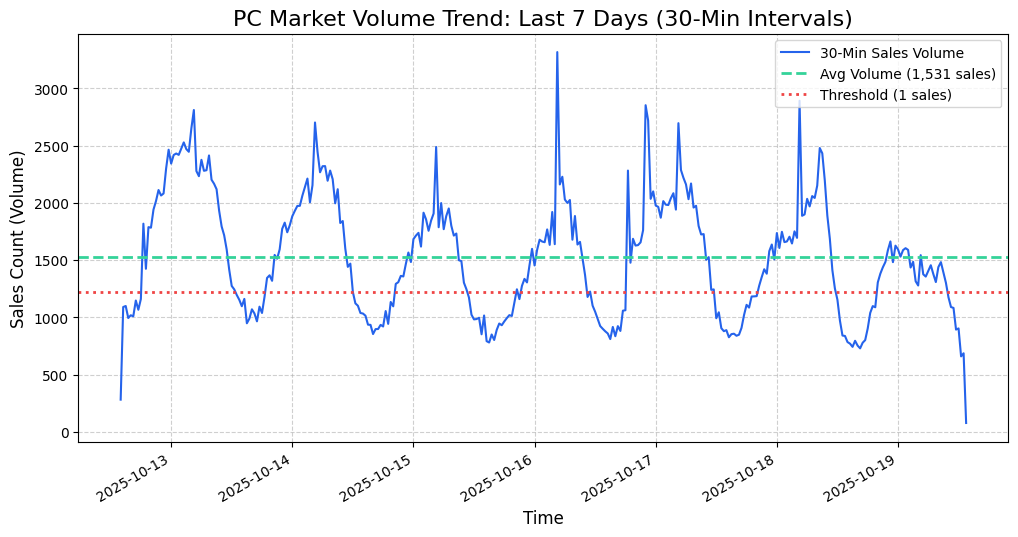

In [ ]:
def plot_volume_trend(sales_df, days=HISTORICAL_DAYS, interval_minutes=INTERVAL_MINUTES):
    """
    Filters data, calculates volume per interval, and plots the trend with
    average and threshold lines.
    """
    sales_df = sales_df.sort_values('sale_time')
    if sales_df.empty:
        print("Error: Sales DataFrame is empty.")
        return
        
    end_time = sales_df['sale_time'].max()
    start_time = end_time - timedelta(days=days)
    
    # 1. Filter data to the historical window
    historical_df = sales_df[(sales_df['sale_time'] >= start_time) & (sales_df['sale_time'] <= end_time)].copy()
    
    if historical_df.empty:
        print(f"Error: No data found in the last {days} days.")
        return
        
    # 2. Bin the data and calculate volume per bin
    historical_df['time_bin'] = historical_df['sale_time'].dt.floor(f'{interval_minutes}min')
    volume_per_bin = historical_df.groupby('time_bin').size()
    
    # 3. Calculate metrics for reference lines
    avg_volume = volume_per_bin.mean()
    
    # 4. Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot the 30-minute volume trend
    plt.plot(volume_per_bin.index, volume_per_bin.values, label='30-Min Sales Volume', color='#2563eb', linewidth=1.5)
    
    # Plot the average volume line
    plt.axhline(avg_volume, 
                color='#34d399', 
                linestyle='--', 
                linewidth=2, 
                label=f'Avg Volume ({avg_volume:,.0f} sales)')
                
    # Plot the suggested threshold line
    plt.axhline(suggested_threshold, 
                color='#ef4444', 
                linestyle=':', 
                linewidth=2, 
                label=f'Threshold ({1:,.0f} sales)')

    # 5. Customize the plot
    plt.title(f'PC Market Volume Trend: Last {days} Days ({interval_minutes}-Min Intervals)', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Sales Count (Volume)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper right')
    
    # Format X-axis to show dates and times cleanly
    plt.gcf().autofmt_xdate()

plot_volume_trend(df_history)

In [ ]:
MIN_ADS_HIGH_SUPPLY = 901 # Minimum Average Daily Sales (ADS) to be considered High-Supply
MAX_ADS_LOW_SUPPLY = 900   # Maximum Average Daily Sales (ADS) to be considered Low-Supply


def get_card_supply_category(sales_df, days=HISTORICAL_DAYS, min_ads_high=MIN_ADS_HIGH_SUPPLY, max_ads_low=MAX_ADS_LOW_SUPPLY):
    """
    Analyzes the sales history (volume) for each unique card (defined by name and version).
    
    Args:
        sales_df (pd.DataFrame): DataFrame containing 'name', 'version', and sales data.
        days (int): The number of days used for the sales calculation.
        min_ads_high (int): Minimum Average Daily Sales (ADS) for High-Supply.
        max_ads_low (int): Maximum Average Daily Sales (ADS) for Low-Supply.

    Returns:
        pd.DataFrame: A DataFrame with identifying columns, 'total_sales', 'avg_daily_sales', and 'card_type'.
    """
    if sales_df.empty:
        return pd.DataFrame()

    # FIX: Group by name and version, as this is the unique identifier in your real data.
    # We also keep the max rating and position to display the primary info for the card item.
    
    # 1. Aggregate sales count
    card_volume = sales_df.groupby(['name', 'version']).size().reset_index(name='total_sales')
    
    # 2. Merge back other identifying features (rating, position)
    # We use a helper dataframe to get the max rating and most common position for the grouped item
    identifier_cols = sales_df[['name', 'version', 'rating', 'position']].drop_duplicates(subset=['name', 'version']).reset_index(drop=True)
    
    # Merge the volume data with the identifier data
    card_volume = pd.merge(card_volume, identifier_cols, on=['name', 'version'], how='left')

    # 3. Calculate Average Daily Sales (ADS)
    card_volume['avg_daily_sales'] = card_volume['total_sales'] / days
    
    # 4. Define supply categories based on ADS thresholds
    def categorize_supply(ads):
        if ads >= min_ads_high:
            return 'High-Supply (Common)'
        elif ads <= max_ads_low:
            return 'Low-Supply (Rare)'
        else:
            return 'Medium-Supply (Tactical)'
            
    card_volume['supply_category'] = card_volume['avg_daily_sales'].apply(categorize_supply)
    
    # Use the appropriate columns for sorting and reporting
    return card_volume[['name', 'version', 'rating', 'position', 'total_sales', 'avg_daily_sales', 'supply_category']].sort_values('avg_daily_sales', ascending=False)


df = df_clean_full[df_clean_full['platform'] == "pc" & df_clean_full['card_id'] == "pc"].copy()

supply_report_df = get_card_supply_category(df)

# The columns to display in the markdown table
display_cols = ['name', 'version', 'supply_category', "avg_daily_sales"]

# Display the top 5 high-supply cards (highest volume)
high_supply_df = supply_report_df[supply_report_df['supply_category'] == 'High-Supply (Common)']
print("\nTop 5 High-Supply Cards (Highest Volume):")
print(high_supply_df.head(5)[display_cols].to_markdown(index=False))

# Low-Supply Cards (Highest ADS within the category)
low_supply_df = supply_report_df[supply_report_df['supply_category'] == 'Low-Supply (Rare)']

print("\nTop 5 Low-Supply Cards (Highest ADS/Least Rare in category):")
print(low_supply_df.head(5)[display_cols].to_markdown(index=False))

# Low-Supply Cards (Lowest ADS within the category - the truly rarest/slowest)
print("\nTop 5 Low-Supply Cards (Lowest ADS/Most Rare in category):")
print(low_supply_df.tail(5)[display_cols].to_markdown(index=False))
    

KeyError: 'supply_category'

In [101]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

# --- GLOBAL LIVE PARAMETERS ---
# Interval for market health check (30 min is optimal for a fast, balanced signal)
LIVE_INTERVAL_MINUTES = 30 
# Threshold for velocity: Index must drop 1.0% in the 30-min window to signal a crash.
CRASH_VELOCITY_THRESHOLD = -4.0 
# Minimum sales volume required in the current 30-min bin for the signal to be reliable.
MIN_VOLUME_THRESHOLD = 500 
# Minimum number of unique cards sold in the current 30-min bin for the signal to be considered broad-market.
MIN_PARTICIPATION_THRESHOLD = 100 
def get_latest_data_bin(sales_df, interval_minutes):
    """
    Filters the sales data to the two most recent complete time bins.
    FIX: Assumes the absolute latest bin is incomplete and discards it.
    """
    
    sales_df = sales_df.sort_values('sale_time')
    
    if sales_df.empty:
        return None, None

    # Determine the time bins
    sales_df['time_bin'] = (sales_df['sale_time'].dt.floor(f'{interval_minutes}min'))
    
    # Get all unique time bins
    all_bins = sales_df['time_bin'].unique()
    
    # We need at least 3 bins: [previous_full, current_full, latest_incomplete]
    if len(all_bins) < 3:
        # Need at least two complete bins for comparison + the final incomplete bin.
        return None, None
    
    # Select the two most recent *complete* bins by ignoring the very last, often incomplete one.
    current_full_bin = all_bins[-2]
    previous_full_bin = all_bins[-3]
    
    recent_bins = [previous_full_bin, current_full_bin] 
    
    # Filter the DataFrame to include only data from these two bins
    data_two_bins = sales_df[sales_df['time_bin'].isin(recent_bins)]
    
    # Return the filtered data and the time of the latest *full* bin
    latest_bin = current_full_bin
    
    return data_two_bins, latest_bin

def calculate_market_index_and_velocity(sales_df):
    """
    Calculates the normalized market index and the crash velocity (log return) 
    using the last two complete time bins.
    """
    # FIX: Ensure LIVE_INTERVAL_MINUTES is used here
    data_two_bins, latest_bin = get_latest_data_bin(sales_df, LIVE_INTERVAL_MINUTES)
    
    if data_two_bins is None:
        return None, None, None

    # Compute average price per bin
    market_index = data_two_bins.groupby('time_bin')['sold_price'].mean()
    
    if market_index.shape[0] < 2:
        return None, None, None

    # Calculate Crash Velocity (Log Return) * 100 for percentage
    latest_index = market_index.iloc[-1]
    previous_index = market_index.iloc[-2]
    
    crash_velocity = np.log(latest_index / previous_index) * 100
    
    # Return the latest index, velocity, and the time of the latest bin
    return latest_index, crash_velocity, latest_bin

def calculate_total_volume(sales_df):
    """Calculates the total number of sales in the latest complete time bin."""
    # FIX: Ensure LIVE_INTERVAL_MINUTES is used here
    data_two_bins, latest_bin = get_latest_data_bin(sales_df, LIVE_INTERVAL_MINUTES)
    
    if data_two_bins is None:
        return 0
    
    # Filter to only the latest bin and count rows (volume)
    latest_bin_data = data_two_bins[data_two_bins['time_bin'] == latest_bin]
    return latest_bin_data.shape[0]

def calculate_unique_cards_sold(sales_df):
    """Calculates the number of unique cards sold in the latest complete time bin."""
    # FIX: Ensure LIVE_INTERVAL_MINUTES is used here
    data_two_bins, latest_bin = get_latest_data_bin(sales_df, LIVE_INTERVAL_MINUTES)
    
    if data_two_bins is None:
        return 0
        
    # Filter to only the latest bin and count unique card IDs
    latest_bin_data = data_two_bins[data_two_bins['time_bin'] == latest_bin]
    return latest_bin_data['card_id'].nunique()

def check_for_live_crash_signal(sales_df):
    """
    Analyzes the most recent market activity (the latest bin) 
    to determine if a validated market crash is occurring.
    """
    # 1. Calculate Crash Velocity (Price Momentum)
    latest_index, crash_velocity, latest_bin = calculate_market_index_and_velocity(sales_df) 
    
    if latest_index is None or crash_velocity is None:
        return "Not enough data to check velocity (requires data from two complete bins)."

    # 2. Calculate Volume/Liquidity Metrics (Market Health)
    # The fix ensures these volume functions now correctly read the 60 min interval
    total_volume = calculate_total_volume(sales_df)
    unique_cards_sold = calculate_unique_cards_sold(sales_df)
    
    # 3. Apply Multi-Factor Logic
    is_price_crashing = (crash_velocity < CRASH_VELOCITY_THRESHOLD)
    is_volume_valid = (total_volume > MIN_VOLUME_THRESHOLD)
    is_participation_valid = (unique_cards_sold > MIN_PARTICIPATION_THRESHOLD)
    
    # Use the 'latest_bin' timestamp, which is rounded down to the interval, for the report time.
    latest_time_str = latest_bin.strftime('%Y-%m-%d %H:%M:%S')
    
    report = [
        f"--- Live Market Check Report (as of {latest_time_str}) ---",
        f"Bin Size: {LIVE_INTERVAL_MINUTES} min | Velocity Threshold: {CRASH_VELOCITY_THRESHOLD:.2f}%"
    ]
    
    if is_price_crashing and is_volume_valid and is_participation_valid:
        # BEST: Strong momentum, high volume, and widespread panic (best signal)
        report.append("🚨 LIVE CRASH SIGNAL! (Validated by High Volume and Participation)")
        report.append(f"-> Velocity: {crash_velocity:.2f}% drop/bin | Volume: {total_volume:,} | Unique Cards: {unique_cards_sold}")
        return "\n".join(report)

    elif is_price_crashing and is_volume_valid and not is_participation_valid:
        # MEDIUM: Price is dropping fast with high volume, but it's focused on a few cards.
        report.append("⚠️ FOCUSED CRASH WARNING: High Velocity, but localized to a few popular cards.")
        report.append(f"-> Velocity: {crash_velocity:.2f}% drop/bin | Unique Cards ({unique_cards_sold}) is below threshold ({MIN_PARTICIPATION_THRESHOLD}).")
        return "\n".join(report)

    elif is_price_crashing and not is_volume_valid:
        # WORST: Price dropping fast, but on very low volume, suggesting noise or illiquidity.
        report.append("📈 PRICE VOLATILITY WARNING: Price dropping fast, but due to LOW VOLUME.")
        report.append(f"-> Velocity: {crash_velocity:.2f}% drop/bin | Volume ({total_volume}) is below threshold ({MIN_VOLUME_THRESHOLD}).")
        return "\n".join(report)

    else:
        # Market is stable or rising
        report.append("✅ Market Stable or Rising.")
        report.append(f"-> Velocity: {crash_velocity:.2f}% | Volume: {total_volume:,} | Unique Cards: {unique_cards_sold}")
        return "\n".join(report)
    

df = df_clean_full[df_clean_full['platform'] == "pc"].copy()
print(check_for_live_crash_signal(df))

--- Live Market Check Report (as of 2025-10-19 13:00:00) ---
Bin Size: 30 min | Velocity Threshold: -4.00%
✅ Market Stable or Rising.
-> Velocity: -0.36% | Volume: 687 | Unique Cards: 157


In [19]:
# --- GLOBAL PARAMETERS ---
LIVE_INTERVAL_MINUTES = 30
CRASH_ZSCORE_THRESHOLD = -2.0   #  Dynamic crash detection threshold
ROLLING_WINDOW_BINS = 20    # For smoothing velocity trends

# Fallback thresholds (used before adaptive thresholds can be computed)
MIN_VOLUME_THRESHOLD_FALLBACK = 800
MIN_PARTICIPATION_THRESHOLD_FALLBACK = 150

# Historical Analysis Parameters
HISTORICAL_DAYS = 7 # <--- Setting history length to one week (7 days)


# --- PREPROCESSING ---
def preprocess_sales_data(sales_df):
    """Prepares sales data and extracts the last two complete time bins."""
    if sales_df.empty:
        return None, None, None, None

    # Filter data to only include the HISTORICAL_DAYS period for stable averages
    end_time = sales_df['sale_time'].max()
    start_time = end_time - timedelta(days=HISTORICAL_DAYS)
    sales_df = sales_df[(sales_df['sale_time'] >= start_time)].copy()

    sales_df = sales_df.sort_values('sale_time').copy()
    sales_df['time_bin'] = sales_df['sale_time'].dt.floor(f'{LIVE_INTERVAL_MINUTES}min')

    all_bins = sales_df['time_bin'].unique()
    
    # We need at least 3 bins: [historical_data, previous_full, current_full]
    # Note: We use [-3] and [-2] because the latest bin [-1] is usually incomplete.
    if len(all_bins) < 3:
        # Returning full sales_df for full historical velocity calculation, but last bins are None
        return sales_df, None, None, None
        
    previous_full_bin, current_full_bin = all_bins[-3], all_bins[-2]
    
    # Return the full sales_df for statistical calculations, and the two latest bins for metrics
    return sales_df, previous_full_bin, current_full_bin, all_bins

def calculate_market_index_and_velocity(sales_df):
    """
    Computes market index and velocity for ALL bins, then focuses on the latest.
    NOTE: The velocity mean/std are calculated over the entire history for robustness.
    """
    sales_df_processed, prev_bin, curr_bin, all_bins = preprocess_sales_data(sales_df)
    
    if sales_df_processed is None or len(all_bins) < 2: 
        return None, None, None, None 

    def _calculate_robust_weighted_average(x):
        prices = x['sold_price']
        weights = x['sold_price'] # Weights are the prices themselves
        
        # FIX: Check if the sum of weights is 0 to prevent ZeroDivisionError
        if weights.sum() == 0:
            return np.nan # Return NaN to ignore this bin in the index calculation
        
        return np.average(prices, weights=weights)

    # 1. Calculate Volume-Weighted Market Index for ALL historical bins (7 days)
    # Uses sold_price as weight to emphasize expensive cards (high price volatility)
    full_market_index = (sales_df_processed.groupby('time_bin')
                         .apply(_calculate_robust_weighted_average))

    # 2. Compute log returns (velocity) for ALL bins (7 days)
    velocities = np.log(full_market_index / full_market_index.shift(1)) * 100
    
    # Check for enough velocity data for stable calculations
    if len(velocities.dropna()) < ROLLING_WINDOW_BINS:
        # Not enough historical velocity to smooth or calculate Z-score reliably
        # We rely on the second to last index/velocity as the "latest" full one
        return full_market_index.iloc[-2], velocities.iloc[-2], 0, curr_bin 

    # 3. Smooth velocity using rolling window (latest smoothed value)
    smoothed_velocity = velocities.rolling(window=ROLLING_WINDOW_BINS, min_periods=2).mean().iloc[-2] # Use [-2] as [-1] is incomplete
    
    # 4. Z-score normalization for adaptive detection (using ALL historical velocities)
    # The mean and std are calculated across the entire 7-day history for statistical stability.
    latest_velocity = velocities.iloc[-2] # Use [-2] as [-1] is incomplete
    z_velocity = (latest_velocity - velocities.mean()) / velocities.std()

    latest_index = full_market_index.iloc[-2] # Use [-2] as [-1] is incomplete
    return latest_index, smoothed_velocity, z_velocity, curr_bin


def calculate_volume_and_participation(sales_df):
    """Returns adaptive thresholds and latest volume/participation metrics."""
    sales_df_processed, prev_bin, curr_bin, all_bins = preprocess_sales_data(sales_df)
    if sales_df_processed is None or curr_bin is None:
        # Fallback to general safety thresholds if not enough historical data
        return 0, 0, MIN_VOLUME_THRESHOLD_FALLBACK, MIN_PARTICIPATION_THRESHOLD_FALLBACK

    # Adaptive baselines from full 7-day history
    avg_volume = sales_df_processed.groupby('time_bin').size().mean()
    avg_participation = sales_df_processed.groupby('time_bin')['card_id'].nunique().mean()

    # Thresholds are 60% of the historical average for the given interval
    min_volume = int(avg_volume * 0.6)
    min_participation = int(avg_participation * 0.6)

    # Metrics for latest bin
    latest_data = sales_df_processed[sales_df_processed['time_bin'] == curr_bin]
    total_volume = latest_data.shape[0]
    unique_cards = latest_data['card_id'].nunique()

    return total_volume, unique_cards, min_volume, min_participation


# --- MAIN CRASH DETECTION ---
def check_for_live_crash_signal(sales_df):
    """Evaluates the latest 30-min market window for crash conditions."""
    latest_index, smoothed_velocity, z_velocity, latest_bin = calculate_market_index_and_velocity(sales_df)
    
    if latest_index is None or latest_bin is None:
        return {"status": "NO_DATA", "report": "Not enough data to detect crash (requires two full 30-min bins)."}

    total_volume, unique_cards, min_vol, min_part = calculate_volume_and_participation(sales_df)

    # Use Z-score for crash condition check
    is_price_crashing = (z_velocity < CRASH_ZSCORE_THRESHOLD)
    
    # Use Adaptive thresholds for validation
    is_volume_valid = (total_volume > min_vol)
    is_participation_valid = (unique_cards > min_part)

    latest_time_str = latest_bin.strftime('%Y-%m-%d %H:%M:%S')

    # --- REPORT LOGIC ---
    report = [
        f"--- Live Market Check (as of {latest_time_str}) ---",
        f"History Used: {HISTORICAL_DAYS} Days | Interval: {LIVE_INTERVAL_MINUTES} min",
        f"Crash Z-Score Threshold: {CRASH_ZSCORE_THRESHOLD}",
        f"Velocity (smoothed): {smoothed_velocity:.2f}% | Z-Score: {z_velocity:.2f}",
        f"Volume: {total_volume:,.0f} (min {min_vol:,.0f}) | Unique Cards: {unique_cards:,.0f} (min {min_part:,.0f})"
    ]

    # --- SIGNAL CLASSIFICATION ---
    if is_price_crashing and is_volume_valid and is_participation_valid:
        report.append("🚨 **VALIDATED CRASH SIGNAL** — High volume & widespread panic.")
        status = "CRASH_CONFIRMED"

    elif is_price_crashing and is_volume_valid and not is_participation_valid:
        report.append("⚠️ **FOCUSED CRASH** — Localized to a few meta cards. High Price Risk!")
        status = "CRASH_LOCALIZED"

    elif is_price_crashing and not is_volume_valid:
        report.append("📈 **LOW-LIQUIDITY VOLATILITY** — Sharp move, but volume is too weak to validate a trend.")
        status = "VOLATILITY_ONLY"

    else:
        report.append("✅ **Market Stable or Recovering.**")
        status = "STABLE"

    return {
        "status": status,
        "velocity": smoothed_velocity,
        "z_velocity": z_velocity,
        "volume": total_volume,
        "unique_cards": unique_cards,
        "report": "\n".join(report)
    }


df = df_clean_full[df_clean_full['platform'] == "pc"].copy()
print(check_for_live_crash_signal(df)["report"])

C:\Users\shane\AppData\Local\Temp\ipykernel_2688\173974464.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_calculate_robust_weighted_average))


--- Live Market Check (as of 2025-10-20 14:00:00) ---
History Used: 7 Days | Interval: 30 min
Crash Z-Score Threshold: -2.0
Velocity (smoothed): -0.48% | Z-Score: 0.34
Volume: 636 (min 897) | Unique Cards: 162 (min 108)
✅ **Market Stable or Recovering.**
